<h1 align="center"> Audio Classification </h1>

- installation of requirements

In [7]:
# pip install -r requirements.txt

# Data:
The "data/raw" folder contains thousands of audio recordings of 10 people (5 men and 5 women) from the United States. The goal of this project is to analyze this data and build a simple speech recognition model. That is, to recognize the speaker among the 10. Here's what a recording looks like:

In [8]:
# pip install librosa
# pip install IPython

In [9]:
from IPython.display import Audio
import librosa
import aifc

y1, sr1 = librosa.load("data/raw/f0001_us_f0001_00001.wav", sr=None)
Audio(data=y1, rate=sr1)

In [10]:
print(y1)
print(f"La taille du fichier audio est {y1.shape}")

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.4414062e-04
 -1.8310547e-04 -6.1035156e-05]
La taille du fichier audio est (74880,)


We will start by extracting timbre information (using the time-frequency domain) from the recording with the Mel Frequency Cepstral Coefficient (MFCC):

In [11]:
mfcc = librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=10)
print(mfcc)
print(f"La taille des coefficients est {mfcc.shape}")

[[-676.00336   -628.5445    -630.0368    ... -587.2241    -618.89246
  -651.83386  ]
 [  37.224003    47.902386    46.276775  ...   56.47776     54.10054
    50.659206 ]
 [  23.102505    21.160933    22.697374  ...   15.998568    18.138077
    22.942192 ]
 ...
 [   6.6952944    6.119456     2.151738  ...   12.616104     8.677282
     9.154581 ]
 [   6.1928906    1.8975844    1.6943827 ...   17.547215    14.1192665
    11.321548 ]
 [  -1.1161003   -5.9224443   -5.2735295 ...    8.176835     5.3311367
     3.8546567]]
La taille des coefficients est (10, 147)


We can visualize these 10 coefficients over time:

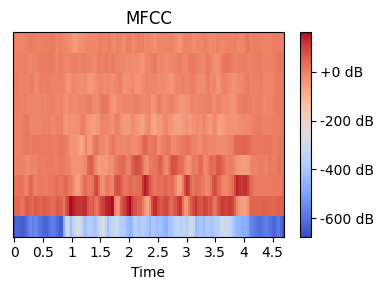

In [12]:
from matplotlib import pyplot as plt

# Plotting the MFCCs
plt.figure(figsize=(4, 3))
librosa.display.specshow(mfcc, x_axis='time', sr=sr1)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.tight_layout()
plt.show()


We will summarize coefficients by calculating the time average. Thus, each audio file must be transformed by a vector of size 13:

In [13]:
mfcc_moyenne = mfcc.mean(axis=1)
mfcc_moyenne

array([-447.81406  ,   63.020832 ,   30.160309 ,    7.9655695,
          2.1016788,  -22.293121 ,   -7.862449 ,  -12.084611 ,
         -1.8244214,   -6.8137836], dtype=float32)

We therefore build the dataset with the following function:

In [14]:
import pandas as pd

folder_path = "data/raw/"
n_recordings = 50
n_coefs = 10
data = []
for gender in ["m", "f"]:
    for speaker in range(1, 6):
        for recording_id in range(1, n_recordings + 1):
            file_name = "%s%04d_us_%s%04d_%05d.wav" %(gender, speaker, gender, speaker, recording_id)
            y, sr = librosa.load(folder_path + file_name)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_coefs).mean(axis=1)

            speaker_id = speaker - 1
            if gender == "f":
                speaker_id += 5
            row_data = {
                'FileName': file_name,
                'Gender': gender,
                'SpeakerID': speaker_id,
                'RecordingID': recording_id,
            }
            for i in range(n_coefs):
                row_data[f'MFCC_{i+1}'] = mfcc[i]
            
            data.append(row_data)

df = pd.DataFrame(data)

In [15]:
df.head(3)

,FileName,Gender,SpeakerID,RecordingID,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,m0001_us_m0001_00001.wav,m,0,1,-432.045410,119.769264,-3.836545,25.336601,-13.802795,16.731417,-2.733350,2.620323,-9.290769,3.606286
1,m0001_us_m0001_00002.wav,m,0,2,-448.635986,114.177422,-5.153250,16.764275,-20.626694,20.666161,-5.741008,9.305303,-5.688132,0.833428
2,m0001_us_m0001_00003.wav,m,0,3,-433.696320,94.268814,-3.704444,24.321095,-15.773800,16.456257,0.998080,5.189481,-8.003876,4.879941


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FileName     500 non-null    object 
 1   Gender       500 non-null    object 
 2   SpeakerID    500 non-null    int64  
 3   RecordingID  500 non-null    int64  
 4   MFCC_1       500 non-null    float32
 5   MFCC_2       500 non-null    float32
 6   MFCC_3       500 non-null    float32
 7   MFCC_4       500 non-null    float32
 8   MFCC_5       500 non-null    float32
 9   MFCC_6       500 non-null    float32
 10  MFCC_7       500 non-null    float32
 11  MFCC_8       500 non-null    float32
 12  MFCC_9       500 non-null    float32
 13  MFCC_10      500 non-null    float32
dtypes: float32(10), int64(2), object(2)
memory usage: 35.3+ KB


# Partie I:
#### - Perform a PCA on the MFCC coefficients by visualizing the gender with two different colors. 


In [17]:
MFCC = df[["MFCC_1", "MFCC_2", "MFCC_3", "MFCC_4", "MFCC_5", "MFCC_6", "MFCC_7", "MFCC_8", "MFCC_9", "MFCC_10"]]

In [18]:
MFCC.head(3)

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,-432.045410,119.769264,-3.836545,25.336601,-13.802795,16.731417,-2.733350,2.620323,-9.290769,3.606286
1,-448.635986,114.177422,-5.153250,16.764275,-20.626694,20.666161,-5.741008,9.305303,-5.688132,0.833428
2,-433.696320,94.268814,-3.704444,24.321095,-15.773800,16.456257,0.998080,5.189481,-8.003876,4.879941


**- Application of PC on MFCC coefficients:**

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale


MFCC_scaled = scale(MFCC)  # Standardise les données
pca = PCA()
pca.fit(MFCC_scaled)  # Applique la PCA sur les données standardisées

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:247: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:266: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


PCA()

In [20]:
cov_matrix = pca.get_covariance()

In [21]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[2.4912393  1.9942381  1.4212061  1.3281538  0.71429914 0.56591046
 0.47757193 0.41103676 0.4027029  0.2136824 ]
[0.24862565 0.19902495 0.14183635 0.13254973 0.07128704 0.05647786
 0.04766167 0.04102146 0.04018974 0.0213255 ]


In [22]:
import numpy as np

eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x) for x in range(1,11)], 
        "Variance explained" : pca.explained_variance_,
        "% Variance explained" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. explained" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance explained,% Variance explained,% cum. var. explained
0,Dim1,2.491239,25.0,25.0
1,Dim2,1.994238,20.0,45.0
2,Dim3,1.421206,14.0,59.0
3,Dim4,1.328154,13.0,72.0
4,Dim5,0.714299,7.0,79.0
5,Dim6,0.565910,6.0,85.0
6,Dim7,0.477572,5.0,90.0
7,Dim8,0.411037,4.0,94.0
8,Dim9,0.402703,4.0,98.0
9,Dim10,0.213682,2.0,100.0


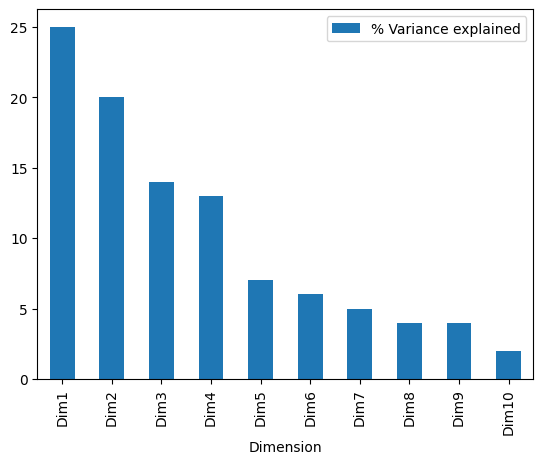

In [23]:
eig.plot.bar(x = "Dimension", y = "% Variance explained")
plt.show()

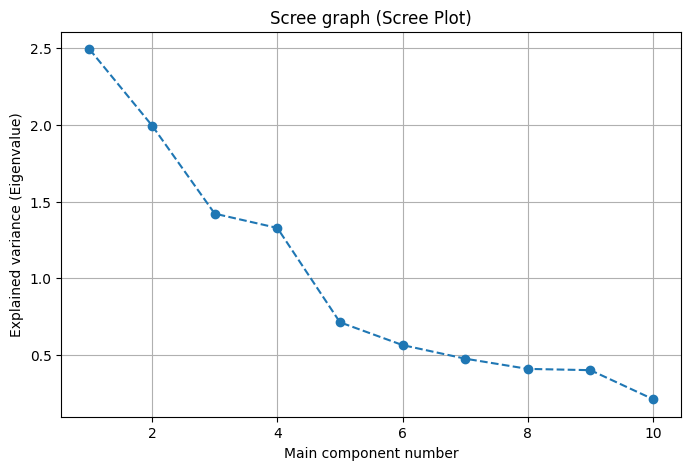

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, marker='o', linestyle='--')
plt.title("Scree graph (Scree Plot)")
plt.xlabel("Main component number")
plt.ylabel("Explained variance (Eigenvalue)")
plt.grid()
plt.show()

According to the scree plot, it is sufficient to retain two principal components to represent the data.

In [25]:
MFCC_pca = pca.transform(MFCC)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [26]:
MFCC_pca_2d = pd.DataFrame({
    "Gender" : df["Gender"],
    "SpeakerID" : df["SpeakerID"],
    "RecordingID" : df["RecordingID"],
    "Dim1" : MFCC_pca[:,0], 
    "Dim2" : MFCC_pca[:,1]
})

MFCC_pca_2d.head()

,Gender,SpeakerID,RecordingID,Dim1,Dim2
0,m,0,1,17.312513,-224.837814
1,m,0,2,16.058979,-238.764694
2,m,0,3,10.549809,-232.116898
3,m,0,4,12.733241,-218.120346
4,m,0,5,7.454394,-213.673340


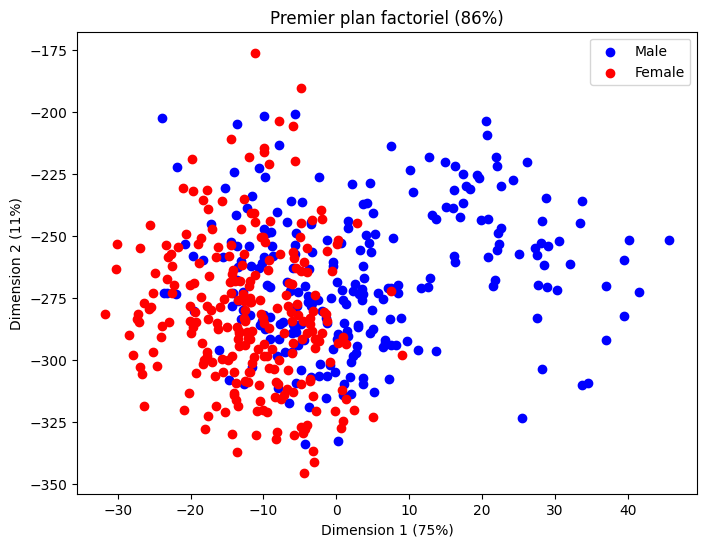

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(MFCC_pca_2d[MFCC_pca_2d['Gender'] == 'm']['Dim1'], MFCC_pca_2d[MFCC_pca_2d['Gender'] == 'm']['Dim2'], color='blue', label='Male')
plt.scatter(MFCC_pca_2d[MFCC_pca_2d['Gender'] == 'f']['Dim1'], MFCC_pca_2d[MFCC_pca_2d['Gender'] == 'f']['Dim2'], color='red', label='Female')

plt.xlabel('Dimension 1 (75%)')
plt.ylabel('Dimension 2 (11%)')
plt.title('Premier plan factoriel (86%)')
plt.legend()

plt.show()

In two dimensions, it is difficult to visualize the data, so we add a third dimension to better distinguish the difference between men and women.

In [28]:
MFCC_pca_3d = pd.DataFrame({
    "Gender" : df["Gender"],
    "SpeakerID" : df["SpeakerID"],
    "RecordingID" : df["RecordingID"],
    "Dim1" : MFCC_pca[:,0], 
    "Dim2" : MFCC_pca[:,1],
    "Dim3" : MFCC_pca[:,2]
})

MFCC_pca_3d.head()

,Gender,SpeakerID,RecordingID,Dim1,Dim2,Dim3
0,m,0,1,17.312513,-224.837814,-17.809196
1,m,0,2,16.058979,-238.764694,-15.975533
2,m,0,3,10.549809,-232.116898,-26.156170
3,m,0,4,12.733241,-218.120346,-17.674591
4,m,0,5,7.454394,-213.673340,-17.390524


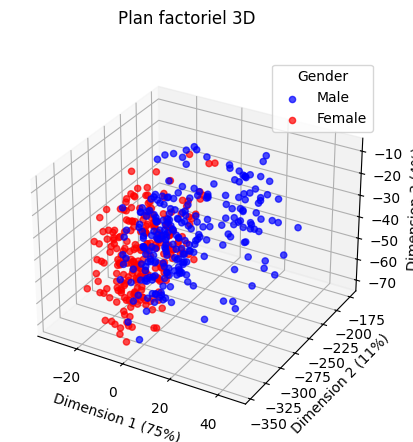

In [29]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Points masculins
ax.scatter(
    MFCC_pca_3d[MFCC_pca_3d["Gender"] == "m"]["Dim1"],
    MFCC_pca_3d[MFCC_pca_3d["Gender"] == "m"]["Dim2"],
    MFCC_pca_3d[MFCC_pca_3d["Gender"] == "m"]["Dim3"],
    c="blue", label="Male", alpha=0.7
)

# Points féminins
ax.scatter(
    MFCC_pca_3d[MFCC_pca_3d["Gender"] == "f"]["Dim1"],
    MFCC_pca_3d[MFCC_pca_3d["Gender"] == "f"]["Dim2"],
    MFCC_pca_3d[MFCC_pca_3d["Gender"] == "f"]["Dim3"],
    c="red", label="Female", alpha=0.7
)

ax.set_xlabel("Dimension 1 (75%)")
ax.set_ylabel("Dimension 2 (11%)")
ax.set_zlabel("Dimension 3 (4%)")
plt.suptitle("Plan factoriel 3D")

plt.legend(title="Gender")

plt.show()

#### - It is suspected that the recordings from `Speaker` 4 form two very distinct subgroups: even and odd `recordingIDs`. Run a test to verify this hypothesis.

In [30]:
speaker_4 = MFCC_pca_2d[MFCC_pca_2d["SpeakerID"] == 4]
speaker_4.head(3)

,Gender,SpeakerID,RecordingID,Dim1,Dim2
200,m,4,1,-12.265306,-238.756088
201,m,4,2,-5.250235,-272.827850
202,m,4,3,-17.190134,-245.137100


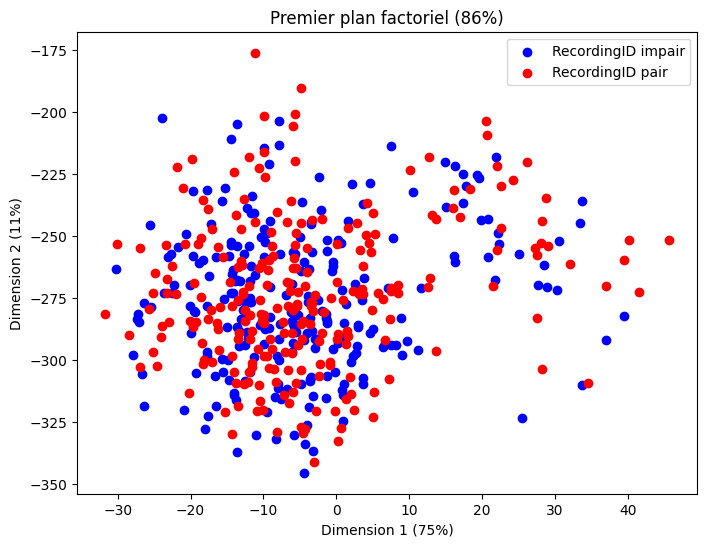

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(MFCC_pca_2d[MFCC_pca_2d["RecordingID"] % 2 != 0]['Dim1'], MFCC_pca_2d[MFCC_pca_2d["RecordingID"] % 2 != 0]['Dim2'], color='blue', label="RecordingID impair")
plt.scatter(MFCC_pca_2d[MFCC_pca_2d["RecordingID"] % 2 == 0]['Dim1'], MFCC_pca_2d[MFCC_pca_2d["RecordingID"] % 2 == 0]['Dim2'], color='red', label="RecordingID pair")

plt.xlabel('Dimension 1 (75%)')
plt.ylabel('Dimension 2 (11%)')
plt.title('Premier plan factoriel (86%)')
plt.legend()

plt.show()

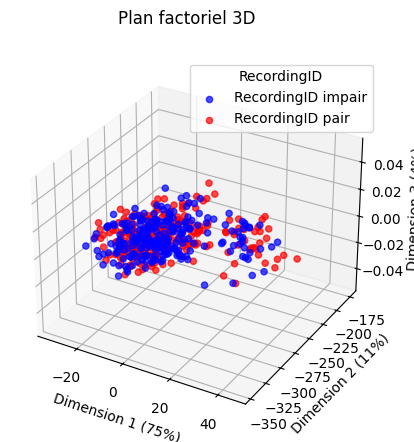

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Points masculins
ax.scatter(
    MFCC_pca_2d[MFCC_pca_2d["RecordingID"] % 2 == 1]["Dim1"],
    MFCC_pca_2d[MFCC_pca_2d["RecordingID"] % 2 == 1]["Dim2"],
    c="blue", label="RecordingID impair", alpha=0.7
)

# Points féminins
ax.scatter(
    MFCC_pca_2d[MFCC_pca_2d["RecordingID"] % 2 == 0]["Dim1"],
    MFCC_pca_2d[MFCC_pca_2d["RecordingID"] % 2 == 0]["Dim2"],
    c="red", label="RecordingID pair", alpha=0.7
)

ax.set_xlabel("Dimension 1 (75%)")
ax.set_ylabel("Dimension 2 (11%)")
ax.set_zlabel("Dimension 3 (4%)")
plt.suptitle("Plan factoriel 3D")

plt.legend(title="RecordingID")

plt.show()

In [33]:
speaker_4[["Dim1", "Dim2"]].describe()

,Dim1,Dim2
count,50.000000,50.000000
mean,-8.436586,-250.043030
std,6.957415,26.809883
min,-23.859447,-332.914276
25%,-12.666313,-268.075844
50%,-8.367582,-248.560158
75%,-4.490963,-234.523033
max,5.339576,-200.682480


In [34]:
speaker_4_pair = speaker_4[speaker_4["RecordingID"] % 2 == 0]
speaker_4_impair = speaker_4[speaker_4["RecordingID"] % 2 != 0]

In [35]:
speaker_4_pair[['Dim1', 'Dim2']].describe()

,Dim1,Dim2
count,25.000000,25.000000
mean,-8.490555,-249.347809
std,7.089097,27.096298
min,-22.024946,-332.914276
25%,-10.653920,-261.041321
50%,-8.627375,-248.694260
75%,-5.583249,-235.831848
max,5.339576,-200.682480


In [36]:
speaker_4_impair[['Dim1', 'Dim2']].describe()

,Dim1,Dim2
count,25.000000,25.000000
mean,-8.382618,-250.738220
std,6.968987,27.060528
min,-23.859447,-296.954376
25%,-12.799982,-269.605957
50%,-7.928256,-247.219833
75%,-3.762452,-234.086761
max,3.631721,-202.567719


- The two distributions are similar in terms of means, with close standard deviations, although Dim1 shows slightly greater variability in the first distribution.

**- Hypothèse nulle $ H_0 $ :** Les enregistrements pairs et impairs n'ont pas de différences significatives sur les dimensions Dim1 et Dim2. Cela implique que la moyenne multivariée des enregistrements pairs est la même que celle des enregistrements impairs :  

$$ \mu_{\text{pair}}  =  \mu_{\text{impair}} $$

où $ \mu_{\text{pair}} $ et $ \mu_{\text{impair}} $ représentent respectivement les moyennes multivariées des enregistrements pairs et impairs.

**- Hypothèse alternative $ H_1 $ :** Il existe une différence significative entre les enregistrements pairs et impairs sur au moins une des dimensions :

$$ \mu_{\text{pair}}  ≠  \mu_{\text{impair}} $$

**- Test de Hotelling :**

In [37]:
speaker4_pair = speaker_4_pair[['Dim1', 'Dim2']]
speaker4_impair = speaker_4_impair[['Dim1', 'Dim2']]

In [38]:
# Taille des échantillons
n1, n2 = len(speaker4_pair), len(speaker4_impair)

$$ \mu_{\text{pair}} = \frac{1}{n_{\text{pair}}} \sum_{i=1}^{n_{\text{pair}}} X_{i}^{(\text{pair})}, \quad \mu_{\text{impair}} = \frac{1}{n_{\text{impair}}} \sum_{i=1}^{n_{\text{impair}}} X_{i}^{(\text{impair})} $$

In [39]:
# Calcul des moyennes des deux groupes
mean1 = speaker4_pair.mean().values
mean2 = speaker4_impair.mean().values

$$ S_{\text{pair}} = \frac{1}{n_{\text{pair}} - 1} \sum_{i=1}^{n_{\text{pair}}} \left( X_{i}^{(\text{pair})} - \mu_{\text{pair}} \right) \left( X_{i}^{(\text{pair})} - \mu_{\text{pair}} \right)^T $$

$$ S_{\text{impair}} = \frac{1}{n_{\text{impair}} - 1} \sum_{i=1}^{n_{\text{impair}}} \left( X_{i}^{(\text{impair})} - \mu_{\text{impair}} \right) \left( X_{i}^{(\text{impair})} - \mu_{\text{impair}} \right)^T $$


In [40]:
# Calcul des matrices de covariance des deux groupes
cov1 = np.cov(speaker4_pair.T)
cov2 = np.cov(speaker4_impair.T)

$$ S_p = \frac{(n_{\text{pair}} - 1) S_{\text{pair}} + (n_{\text{impair}} - 1) S_{\text{impair}}}{n_{\text{pair}} + n_{\text{impair}} - 2} $$


In [41]:
# Matrice de covariance pondérée (estimée)
Sp = ((n1 - 1) * cov1 + (n2 - 1) * cov2) / (n1 + n2 - 2)

$$ \Delta \mu = \mu_{\text{pair}} - \mu_{\text{impair}} $$

$$ T^2 = \frac{n_{\text{pair}} n_{\text{impair}}}{n_{\text{pair}} + n_{\text{impair}}} \Delta \mu^T S_p^{-1} \Delta \mu $$


In [42]:
# Différence entre les moyennes
mean_diff = mean1 - mean2

# Calcul de la statistique T^2
T_squared = (n1 * n2) / (n1 + n2) * mean_diff.T @ np.linalg.inv(Sp) @ mean_diff

$$ F = \frac{(n_{\text{pair}} + n_{\text{impair}} - 2) \cdot p \cdot T^2}{(n_{\text{pair}} + n_{\text{impair}} - p - 1)} $$

$$ df_1 = p $$

$$ df_2 = n_{\text{pair}} + n_{\text{impair}} - p - 1 $$

$$ \text{p-value} = 1 - F_{\text{cdf}}(F, df_1, df_2) $$

In [43]:
from scipy.stats import f

# Conversion de T^2 en statistique F
p = len(mean_diff)  # Nombre de dimensions (2 dans ce cas)
F_statistic = (T_squared * (n1 + n2 - p - 1)) / ((n1 + n2 - 2) * p)

# Degrés de liberté pour le test F
df1, df2 = p, n1 + n2 - p - 1

# Calcul de la p-valeur
p_value = 1 - f.cdf(F_statistic, df1, df2)


In [44]:
# Affichage des résultats
print("Statistique T^2 de Hotelling:", T_squared)
print("Statistique F correspondante:", F_statistic)
print("Degrés de liberté:", df1, "et", df2)
print("p-valeur:", p_value)

Statistique T^2 de Hotelling: 0.033018522469780126
Statistique F correspondante: 0.01616531829249652
Degrés de liberté: 2 et 47
p-valeur: 0.9839701075535761


In [45]:
# Interprétation du résultat
alpha = 0.05  # Niveau de signification
if p_value < alpha:
    print("Il y a une différence significative entre les deux groupes.")
else:
    print("Aucune différence significative n'a été trouvée entre les deux groupes.")

Aucune différence significative n'a été trouvée entre les deux groupes.


#### 3. Proposez une analyse statistique (et effectuez la) pour évaluer si différence entre les hommes et les femmes est significative. 


**- Hypothèse nulle $ H_0 \$ :** Les enregistrements pairs et impairs n'ont pas de différences significatives sur les dimensions Dim1 et Dim2. Cela implique que la moyenne multivariée des enregistrements pairs est la même que celle des enregistrements impairs :  

$$ \mu_{\text{male}}  =  \mu_{\text{female}} $$

où $ \mu_{\text{male}} $ et $ \mu_{\text{female}} $ représentent respectivement les moyennes multivariées des enregistrements male et female.

**- Hypothèse alternative $ H_1 $ :** Il existe une différence significative entre les enregistrements pairs et impairs sur au moins une des dimensions :

$$ \mu_{\text{male}}  ≠  \mu_{\text{female}} $$

**- Test de Hotelling :**

In [46]:
group_male = MFCC_pca_2d[MFCC_pca_2d["Gender"] == 'm']
group_female = MFCC_pca_2d[MFCC_pca_2d["Gender"] == 'f']

In [47]:
group_male_t = group_male[['Dim1', 'Dim2']]
group_female_t = group_female[['Dim1', 'Dim2']]

In [48]:
# Taille des échantillons
n1, n2 = len(group_male_t), len(group_female_t)

# Calcul des moyennes des deux groupes
mean1 = group_male_t.mean().values
mean2 = group_female_t.mean().values

# Calcul des matrices de covariance des deux groupes
cov1 = np.cov(group_male_t.T)
cov2 = np.cov(group_female_t.T)

# Matrice de covariance pondérée (estimée)
Sp = ((n1 - 1) * cov1 + (n2 - 1) * cov2) / (n1 + n2 - 2)

# Différence entre les moyennes
mean_diff = mean1 - mean2

# Calcul de la statistique T^2
T_squared = (n1 * n2) / (n1 + n2) * mean_diff.T @ np.linalg.inv(Sp) @ mean_diff

# Conversion de T^2 en statistique F
p = len(mean_diff)  # Nombre de dimensions (2 dans ce cas)
F_statistic = (T_squared * (n1 + n2 - p - 1)) / ((n1 + n2 - 2) * p)

# Degrés de liberté pour le test F
df1, df2 = p, n1 + n2 - p - 1

# Calcul de la p-valeur
p_value = 1 - f.cdf(F_statistic, df1, df2)

# Affichage des résultats
print("Statistique T^2 de Hotelling:", T_squared)
print("Statistique F correspondante:", F_statistic)
print("Degrés de liberté:", df1, "et", df2)
print("p-valeur:", p_value)

Statistique T^2 de Hotelling: 235.09201893689934
Statistique F correspondante: 117.3099733048584
Degrés de liberté: 2 et 497
p-valeur: 1.1102230246251565e-16


In [49]:
# Interprétation du résultat
alpha = 0.05  # Niveau de signification
if p_value < alpha:
    print("Il y a une différence significative entre les deux groupes.")
else:
    print("Aucune différence significative n'a été trouvée entre les deux groupes.")

Il y a une différence significative entre les deux groupes.


#### - Given this result, how can we implement a prediction model (with numpy only) of gender based on the calculation of a distance?

The Mahalanobis distance is a measure of the distance between a point $ \mathbf{x} $ and a multivariate distribution of points characterized by a mean $ \boldsymbol{\mu} $ and a covariance matrix $ \Sigma $. It is defined by the following formula:


$$ D_{\Sigma}(\mathbf{x}, \boldsymbol{\mu}) = \sqrt{(\mathbf{x} - \boldsymbol{\mu})^T \Sigma^{-1} (\mathbf{x} - \boldsymbol{\mu})} $$


where:
- $ \mathbf{x} $ is the vector of coordinates of the point
- $ \boldsymbol{\mu} $ is the vector of variable means
- $ \Sigma^{-1} $ is the inverse of the covariance matrix.

This distance takes into account the variance of the data and the correlations between variables, making it suitable for multidimensional data.

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Données d'entraînement
X = MFCC_pca_2d[['Dim1', 'Dim2']].values  # Caractéristiques d'entraînement
y = np.where(MFCC_pca_2d['Gender'] == 'm', 0, 1)  # 'm' -> 0 et 'f' -> 1

# Séparer les données en ensembles d'entraînement et de test (80% entraînement, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calcul des noyaux (centroïdes) pour chaque classe
centroid_male = X_train[y_train == 0].mean(axis=0)  # Noyau pour la classe "Male"
centroid_female = X_train[y_train == 1].mean(axis=0)  # Noyau pour la classe "Female"

# Matrices de covariance pour chaque classe
cov_male = np.cov(X_train[y_train == 0], rowvar=False)
cov_female = np.cov(X_train[y_train == 1], rowvar=False)

# Fonction pour calculer la distance de Mahalanobis
def mahalanobis_distance(point, centroid, cov_matrix):
    diff = point - centroid
    return np.sqrt(diff.T @ np.linalg.inv(cov_matrix) @ diff)

# Prédiction de la classe d'un nouveau point
def predict_gender(test_point):
    # Calcul des distances de Mahalanobis entre le point de test et les noyaux
    distance_to_male = mahalanobis_distance(test_point, centroid_male, cov_male)
    distance_to_female = mahalanobis_distance(test_point, centroid_female, cov_female)
    
    # Choisir la classe avec la distance minimale et retourner 0 pour 'Male' et 1 pour 'Female'
    return 0 if distance_to_male < distance_to_female else 1

# Prédictions sur l'ensemble de test
y_pred = [predict_gender(point) for point in X_test]

# Évaluation de la précision du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Précision du modèle sur les données de test:", accuracy)

Précision du modèle sur les données de test: 0.63


# Partie II: Reconnaissance vocale
On souhaite désormais apprendre à prédire `Y = speaker_id` avec les données `X = MFCCS` en utilisant des modèles de classification (avec scikit-learn). On découpe le dataset en deux parties:
- `(X_train, y_train)`: utilisé pour "entrainer" le modèle, c-à-d on suppose que les `y_train` sont connues.
- `(X_train, y_test)`: utilisé pour "tester" le modèle, c-à-d on suppose que les `y_train` ne sont pas connues à l'avance et sont utilisés uniquement après avoir entrainé le modèle pour l'évaluer.


In [51]:
from sklearn.model_selection import train_test_split

X = df[[f"MFCC_{i}" for i in range(1, 11)]].values
y = df.SpeakerID.values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True, test_size=0.25)

#### 5. Évaluez la performance du modèle Naive Bayes en terme de précision de prédiction sur le train et le test. 

- Avant d'appliquer l'algorithme de Naive Bayes, il est important de vérifier l'indépendance entre les coefficients MFCC.  
On calcule la matrice de corrélation entre les coefficients MFCC pour évaluer le degré de dépendance entre eux.

In [52]:
df.columns

Index(['FileName', 'Gender', 'SpeakerID', 'RecordingID', 'MFCC_1', 'MFCC_2',
       'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9',
       'MFCC_10'],
      dtype='object')

In [53]:
corr = df[['MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10']].corr()
corr

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
MFCC_1,1.000000,0.244623,-0.471148,-0.056725,-0.079255,-0.207904,-0.007963,-0.185441,-0.426129,-0.091129
MFCC_2,0.244623,1.000000,-0.355652,-0.344302,0.225649,0.210325,0.290493,-0.051387,0.036607,0.129644
MFCC_3,-0.471148,-0.355652,1.000000,0.123801,0.083347,0.222741,-0.124568,0.295568,0.038416,-0.158331
MFCC_4,-0.056725,-0.344302,0.123801,1.000000,-0.173748,-0.083474,-0.598425,0.025972,-0.439117,-0.328615
MFCC_5,-0.079255,0.225649,0.083347,-0.173748,1.000000,0.152956,0.423377,-0.123639,0.284737,-0.209065
MFCC_6,-0.207904,0.210325,0.222741,-0.083474,0.152956,1.000000,-0.023766,0.345664,-0.088343,0.087713
MFCC_7,-0.007963,0.290493,-0.124568,-0.598425,0.423377,-0.023766,1.000000,-0.185910,0.364965,0.136341
MFCC_8,-0.185441,-0.051387,0.295568,0.025972,-0.123639,0.345664,-0.185910,1.000000,-0.086175,0.113979
MFCC_9,-0.426129,0.036607,0.038416,-0.439117,0.284737,-0.088343,0.364965,-0.086175,1.000000,0.288257
MFCC_10,-0.091129,0.129644,-0.158331,-0.328615,-0.209065,0.087713,0.136341,0.113979,0.288257,1.000000


In [54]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Initialiser le modèle Naive Bayes Gaussien
gnb = GaussianNB()

# Entraîner le modèle sur les données d'entraînement
gnb.fit(X_train, y_train)

# Prédictions sur l'ensemble d'entraînement et de test
y_train_pred = gnb.predict(X_train)
y_test_pred = gnb.predict(X_test)

# Calculer la précision de prédiction sur l'ensemble d'entraînement et de test
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Précision de Naive Bayes sur l'ensemble d'entraînement:", train_accuracy)
print("Précision de Naive Bayes sur l'ensemble de test:", test_accuracy)

Précision de Naive Bayes sur l'ensemble d'entraînement: 0.84
Précision de Naive Bayes sur l'ensemble de test: 0.728


Text(0.5, 1.0, 'Confusion Matrice pour Naive Bayes Guaussian')

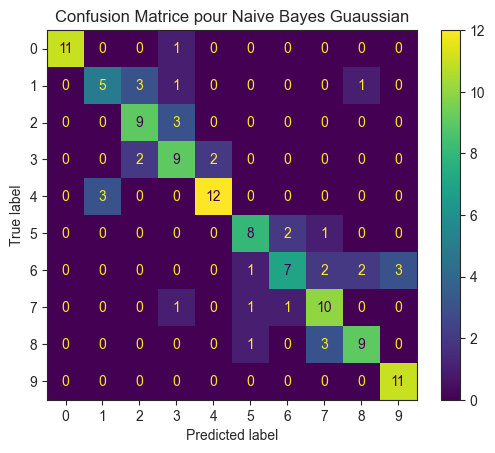

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

sns.set_style('ticks')
ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred)).plot()
plt.title("Confusion Matrice pour Naive Bayes Guaussian")

#### 6. Comparez ses performances avec LDA et QDA. Que pouvez-vous conclure ?

In [56]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

- LDA :

In [57]:
lda = LinearDiscriminantAnalysis()

lda.fit(X_train, y_train)

y_train_pred_lda = lda.predict(X_train)
y_test_pred_lda = lda.predict(X_test)

accuracy_lda_test = accuracy_score(y_test, y_test_pred_lda)
accuracy_lda_train = accuracy_score(y_train, y_train_pred_lda)

print(f"Précision de LDA sur l'ensemble de train : {accuracy_lda_train}")
print(f"Précision de LDA sur l'ensemble de test : {accuracy_lda_test}")

Précision de LDA sur l'ensemble de train : 0.9173333333333333
Précision de LDA sur l'ensemble de test : 0.856


Text(0.5, 1.0, 'Confusion Matrice pour LDA')

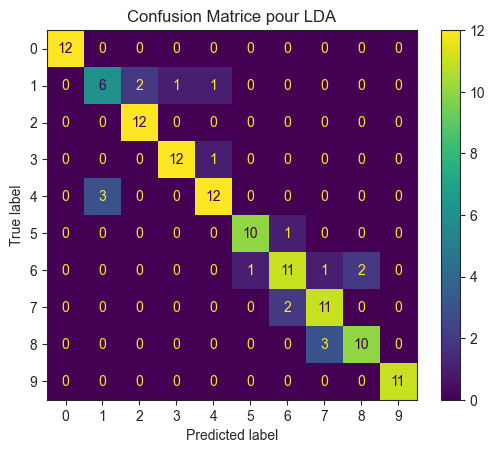

In [58]:
sns.set_style('ticks')
ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred_lda)).plot()
plt.title("Confusion Matrice pour LDA")

- QDA :

In [59]:
qda = QuadraticDiscriminantAnalysis()

qda.fit(X_train, y_train)

y_train_pred_qda = qda.predict(X_train)
y_test_pred_qda = qda.predict(X_test)

accuracy_qda_test = accuracy_score(y_test, y_test_pred_qda)
accuracy_qda_train = accuracy_score(y_train, y_train_pred_qda)

print(f"Précision de QDA sur l'ensemble de train : {accuracy_qda_train}")
print(f"Précision de QDA sur l'ensemble de test : {accuracy_qda_test}")

Précision de QDA sur l'ensemble de train : 0.984
Précision de QDA sur l'ensemble de test : 0.888


Text(0.5, 1.0, 'Confusion Matrice pour QDA')

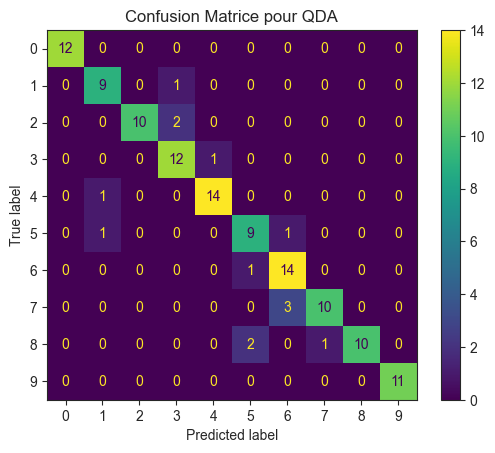

In [60]:
sns.set_style('ticks')
ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred_qda)).plot()
plt.title("Confusion Matrice pour QDA")

En se basant sur la précision de l’ensemble de test, **QDA** est le plus performant avec **88.8%**, suivi de **LDA** à **85.6%**, tandis que **Naive Bayes** atteint seulement **73%**.   
Cela indique que **QDA** et **LDA** capturent mieux la structure des données, probablement en raison de leur capacité à modéliser des relations plus complexes (QDA) ou des frontières de décision linéaires (LDA), alors que Naive Bayes fait des hypothèses d'indépendance plus simplifiées.

#### 7. On souhaite à présent modéliser la distribution de chaque speaker par un mélange de Gaussiennes. Comment peut-on faire des prédictions avec un tel modèle ?

In [61]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
# Initialisation des paramètres
n_components = 1  # Choix du nombre de composantes pour chaque speaker
covariance_type = 'full'

# Stocker les modèles GMM pour chaque speaker
models = {}

# Entraîner un modèle pour chaque speaker
for speaker in np.unique(y_train):
    # Filtrer les données pour le speaker actuel
    X_train_speaker = X_train[y_train == speaker]
    
    # Initialiser et entraîner le GMM pour le speaker
    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=0)
    gmm.fit(X_train_speaker)
    
    # Stocker le modèle GMM du speaker
    models[speaker] = gmm

# Fonction de prédiction
def predict_speaker(X):
    # Calculer les scores (log-vraisemblance) pour chaque modèle de speaker
    scores = np.array([model.score_samples(X) for model in models.values()]).T
    
    # Choisir le speaker avec le score maximal pour chaque échantillon
    predictions = np.argmax(scores, axis=1)
    return np.array(list(models.keys()))[predictions]

# Prédiction sur l'ensemble de test
y_pred = predict_speaker(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle GMM : {accuracy:.2%}")


Précision du modèle GMM : 88.00%


#### 8. Comparez les performances du mélange de Gaussienens en essayant plusieurs combinaisaisons de ses arguments (`n_components` et `covariance_type`). Que pouvez-vous conclure ?

In [62]:
# Options de paramètres
n_components_options = [1, 2, 3, 5]  # Nombre de composantes possibles
covariance_type_options = ['full', 'tied', 'diag', 'spherical']  # Types de covariance
reg_covar = 1e-6  # Valeur de régularisation de la covariance (peut être ajustée)

# Stocker les résultats
results = []

for n_components in n_components_options:
    for covariance_type in covariance_type_options:
        # Dictionnaire pour stocker les modèles par speaker
        models = {}
        
        for speaker in np.unique(y_train):
            # Filtrer les données pour le speaker actuel
            X_train_speaker = X_train[y_train == speaker]
            
            # Initialiser et entraîner le GMM avec régularisation
            gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, 
                                  reg_covar=reg_covar, random_state=0)
            try:
                gmm.fit(X_train_speaker)
                models[speaker] = gmm
            except ValueError:
                print(f"Erreur pour le speaker {speaker} avec n_components={n_components} et covariance_type={covariance_type}")
                continue

        # Prédire sur l'ensemble de test
        def predict_speaker(X):
            scores = np.array([model.score_samples(X) for model in models.values()]).T
            predictions = np.argmax(scores, axis=1)
            return np.array(list(models.keys()))[predictions]
        
        y_pred = predict_speaker(X_test)
        
        # Calcul de l'accuracy pour la combinaison actuelle de paramètres
        accuracy = accuracy_score(y_test, y_pred)
        
        # Stocker les résultats
        results.append((n_components, covariance_type, accuracy))
        print(f"n_components={n_components}, covariance_type='{covariance_type}', Accuracy: {accuracy:.2f}")

# Tri des résultats par précision pour les afficher
sorted_results = sorted(results, key=lambda x: x[2], reverse=True)
print("\nRésultats triés par précision :")
for res in sorted_results:
    print(f"n_components={res[0]}, covariance_type='{res[1]}', Accuracy: {res[2]:.2f}")


n_components=1, covariance_type='full', Accuracy: 0.88
n_components=1, covariance_type='tied', Accuracy: 0.88
n_components=1, covariance_type='diag', Accuracy: 0.74
n_components=1, covariance_type='spherical', Accuracy: 0.54
n_components=2, covariance_type='full', Accuracy: 0.80
n_components=2, covariance_type='tied', Accuracy: 0.90
n_components=2, covariance_type='diag', Accuracy: 0.80
n_components=2, covariance_type='spherical', Accuracy: 0.62
n_components=3, covariance_type='full', Accuracy: 0.65
n_components=3, covariance_type='tied', Accuracy: 0.90
Erreur pour le speaker 4 avec n_components=3 et covariance_type=diag
n_components=3, covariance_type='diag', Accuracy: 0.74
Erreur pour le speaker 4 avec n_components=3 et covariance_type=spherical
n_components=3, covariance_type='spherical', Accuracy: 0.66
n_components=5, covariance_type='full', Accuracy: 0.50
n_components=5, covariance_type='tied', Accuracy: 0.87
Erreur pour le speaker 4 avec n_components=5 et covariance_type=diag
n_c

- Les meilleurs résultats sont obtenus avec **n_components=2** et **n_components=3** et **covariance_type='tied'** .

#### 9. Comment peut-on utiliser le test du rapport de vraisemlance pour comparer ces modèles ? 

- **Hypothèse nulle $ H_0 $ :** Le modèle avec 2 composantes (GMM avec $ n\_\text{components} = 2 $) fournit un ajustement aux données aussi bon que le modèle avec 3 composantes. Autrement dit, il n'y a pas de gain significatif en utilisant un modèle avec plus de composantes pour représenter les données.

$$ \text{log-likelihood}_{\text{2 composantes}} = \text{log-likelihood}_{\text{3 composantes}} $$

- **Hypothèse alternative $ H_1 $ :** Le modèle avec 3 composantes (GMM avec $ n\_\text{components} = 3 $) fournit un ajustement significativement meilleur que le modèle avec 2 composantes, indiquant qu'un modèle plus complexe est nécessaire pour mieux capturer la distribution des données.

$$ \text{log-likelihood}_{\text{2 composantes}} \neq \text{log-likelihood}_{\text{3 composantes}} $$


**- Test du rapport de vraisemlance :**

In [63]:
from scipy.stats import chi2

# Charger et préparer les données
# X_train = ...  # Assurez-vous que X_train contient les données d'entraînement

# Entraîner les deux modèles GMM
gmm1 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
gmm1.fit(X_train)
log_likelihood1 = gmm1.score(X_train) * X_train.shape[0]  # Log-vraisemblance totale

gmm2 = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
gmm2.fit(X_train)
log_likelihood2 = gmm2.score(X_train) * X_train.shape[0]  # Log-vraisemblance totale

# Calcul du rapport de vraisemblance
lambda_stat = 2 * (log_likelihood2 - log_likelihood1)

# Calcul des degrés de liberté
# Par exemple, supposons que les deux modèles sont en covariance 'full' et ont d dimensions
d = X_train.shape[1]
params1 = 2 * (d + d * (d + 1) / 2)
params2 = 3 * (d + d * (d + 1) / 2)
ddl = params2 - params1

# Calcul de la p-valeur pour le test du chi-deux
p_value = chi2.sf(lambda_stat, ddl)

print(f"Statistique du rapport de vraisemblance: {lambda_stat:.2f}")
print(f"Degrés de liberté: {ddl}")
print(f"P-valeur: {p_value}")

if p_value < 0.05:
    print("Le modèle avec plus de composantes fournit un ajustement significativement meilleur.")
else:
    print("Pas de différence significative dans l'ajustement.")


Statistique du rapport de vraisemblance: 472.10
Degrés de liberté: 65.0
P-valeur: 4.26509739311806e-63
Le modèle avec plus de composantes fournit un ajustement significativement meilleur.


#### 10: Evaluez la performance avec le modèle de classification de votre choix (scikit-learn) et interpretez le résultat. Le meilleur score sur des données de validation (privées) aura une note supplémentaire.

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Listes pour stocker les résultats
train_accuracies = []
test_accuracies = []

# Liste des modèles de classification
models = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine": SVC(kernel='linear', random_state=0),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=0),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=0)
}

# Entraîner chaque modèle et évaluer les performances
for model_name, model in models.items():
    # Entraîner le modèle
    model.fit(X_train, y_train)
    
    # Prédictions sur l'ensemble d'entraînement et de test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculer l'accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Stocker les résultats
    train_accuracies.append((model_name, train_accuracy))
    test_accuracies.append((model_name, test_accuracy))
    
    # Afficher les résultats pour chaque modèle
    print(f"{model_name} - Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")

# Afficher tous les résultats triés par précision sur l'ensemble de test
print("\nRésultats triés par précision sur l'ensemble de test:")
sorted_test_accuracies = sorted(test_accuracies, key=lambda x: x[1], reverse=True)
for model_name, test_accuracy in sorted_test_accuracies:
    train_accuracy = dict(train_accuracies)[model_name]
    print(f"{model_name} - Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")


K-Nearest Neighbors - Train Accuracy: 0.86, Test Accuracy: 0.75
Support Vector Machine - Train Accuracy: 0.99, Test Accuracy: 0.86
Decision Tree - Train Accuracy: 1.00, Test Accuracy: 0.58
Random Forest - Train Accuracy: 1.00, Test Accuracy: 0.77
Logistic Regression - Train Accuracy: 0.92, Test Accuracy: 0.78

Résultats triés par précision sur l'ensemble de test:
Support Vector Machine - Train Accuracy: 0.99, Test Accuracy: 0.86
Logistic Regression - Train Accuracy: 0.92, Test Accuracy: 0.78
Random Forest - Train Accuracy: 1.00, Test Accuracy: 0.77
K-Nearest Neighbors - Train Accuracy: 0.86, Test Accuracy: 0.75
Decision Tree - Train Accuracy: 1.00, Test Accuracy: 0.58


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- On va prendre 60% des donnees pour l'entrainement, 20% pour le test et 20% pour la validation.

In [65]:
# Première division pour obtenir un ensemble d'entraînement et un ensemble temporaire
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=0)

# Deuxième division de l'ensemble temporaire pour obtenir validation et test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# Calcul de l'accuracy pour chaque modèle sur train, validation et test
for name, model in models.items():
    # Entraîner le modèle
    model.fit(X_train, y_train)
    
    # Prédictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Calcul de l'accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Afficher les résultats
    print(f"{name}:")
    print(f"  Accuracy sur l'entraînement: {train_accuracy:.2f}")
    print(f"  Accuracy sur le test: {test_accuracy:.2f}")
    print(f"  Accuracy sur la validation: {val_accuracy:.2f}\n")

K-Nearest Neighbors:
  Accuracy sur l'entraînement: 0.86
  Accuracy sur le test: 0.68
  Accuracy sur la validation: 0.79

Support Vector Machine:
  Accuracy sur l'entraînement: 0.99
  Accuracy sur le test: 0.83
  Accuracy sur la validation: 0.82

Decision Tree:
  Accuracy sur l'entraînement: 1.00
  Accuracy sur le test: 0.59
  Accuracy sur la validation: 0.60

Random Forest:
  Accuracy sur l'entraînement: 1.00
  Accuracy sur le test: 0.75
  Accuracy sur la validation: 0.77

Logistic Regression:
  Accuracy sur l'entraînement: 0.96
  Accuracy sur le test: 0.74
  Accuracy sur la validation: 0.75



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- Le modèle ayant obtenu le meilleur score sur les données de validation est : **Support Vector Machine (SVM)**.

#### Bonus: Enrichissez le dataset avec des enregistrements de votre propre voix. Le modèle est-il capable de vous reconnaitre ?

In [67]:
import os

# Chemin vers le dossier contenant les fichiers audio .wav
folder_path = r"C:\Users\HP\Desktop\audio classification\audios"

# Paramètres
n_recordings = 30
n_coefs = 10  # Nombre de coefficients MFCC

# Liste pour stocker les données du dataset
data = []

# Parcourir tous les fichiers .wav dans le dossier
for recording_id, file_name in enumerate(os.listdir(folder_path), start=1):
    if file_name.endswith(".wav") and recording_id <= n_recordings:
        # Chemin complet du fichier audio
        full_file_path = os.path.join(folder_path, file_name)
        
        # Charger l'audio avec librosa
        try:
            y, sr = librosa.load(full_file_path, sr=None)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_coefs).mean(axis=1)
            
            # Ajouter les informations pour chaque fichier
            row_data = {
                'FileName': file_name,
                'Gender': 'm',            # Supposé comme 'm', modifiable si nécessaire
                'SpeakerID': 10,          # ID de l'interlocuteur, modifiable si nécessaire
                'RecordingID': recording_id
            }
            # Ajouter chaque coefficient MFCC en tant que colonne
            for i in range(n_coefs):
                row_data[f'MFCC_{i+1}'] = mfcc[i]
            
            # Ajouter la ligne au dataset
            data.append(row_data)
        
        except Exception as e:
            print(f"Erreur lors du traitement de {file_name}: {e}")

# Créer le DataFrame à partir des données
data_propre = pd.DataFrame(data)

# Afficher et sauvegarder le DataFrame
print(data_propre.head())
data_propre.to_csv("audio_dataset.csv", index=False)
print("Dataset créé et sauvegardé sous 'audio_dataset.csv'")


                                            FileName Gender  SpeakerID  \
0  WhatsApp_Audio_20241110_à_17.03.42_e1365492.wa...      m         10   
1  WhatsApp_Audio_20241110_à_17.03.53_314de098.wa...      m         10   
2  WhatsApp_Audio_20241110_à_17.04.57_187aefab.wa...      m         10   
3  WhatsApp_Audio_20241110_à_17.05.06_8a67a485.wa...      m         10   
4  WhatsApp_Audio_20241110_à_17.05.15_139907cd.wa...      m         10   

   RecordingID      MFCC_1     MFCC_2     MFCC_3     MFCC_4     MFCC_5  \
0            1 -409.924469  93.478333  12.355265  32.322983  18.146904   
1            2 -353.183594  74.487946  27.264940  48.069912  -3.084020   
2            3 -441.948181  72.475838  20.277792  39.130638   2.327709   
3            4 -349.856445  88.758888  29.450577  52.606888  -5.944115   
4            5 -368.518402  87.385040  13.515821  44.552917   7.109288   

     MFCC_6     MFCC_7    MFCC_8     MFCC_9    MFCC_10  
0  0.870184 -17.155094  4.730425  -8.291381 -11.59527

In [68]:
data_propre.head(3)

,FileName,Gender,SpeakerID,RecordingID,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,WhatsApp_Audio_20241110_à_17.03.42_e1365492.wa...,m,10,1,-409.924469,93.478333,12.355265,32.322983,18.146904,0.870184,-17.155094,4.730425,-8.291381,-11.595270
1,WhatsApp_Audio_20241110_à_17.03.53_314de098.wa...,m,10,2,-353.183594,74.487946,27.264940,48.069912,-3.084020,8.159304,-12.881674,-7.010940,-4.315077,-7.766172
2,WhatsApp_Audio_20241110_à_17.04.57_187aefab.wa...,m,10,3,-441.948181,72.475838,20.277792,39.130638,2.327709,1.939173,-7.226953,-7.143674,0.402618,-2.011796


In [69]:
new_df = pd.concat([df, data_propre], ignore_index=True)
new_df

,FileName,Gender,SpeakerID,RecordingID,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,m0001_us_m0001_00001.wav,m,0,1,-432.045410,119.769264,-3.836545,25.336601,-13.802795,16.731417,-2.733350,2.620323,-9.290769,3.606286
1,m0001_us_m0001_00002.wav,m,0,2,-448.635986,114.177422,-5.153250,16.764275,-20.626694,20.666161,-5.741008,9.305303,-5.688132,0.833428
2,m0001_us_m0001_00003.wav,m,0,3,-433.696320,94.268814,-3.704444,24.321095,-15.773800,16.456257,0.998080,5.189481,-8.003876,4.879941
3,m0001_us_m0001_00004.wav,m,0,4,-427.338989,113.769791,-8.063370,25.546106,-15.735123,12.846508,-0.483539,5.328898,-16.783321,1.889776
4,m0001_us_m0001_00005.wav,m,0,5,-412.676575,102.270454,-9.136461,29.005512,-12.034924,23.754642,-7.142556,-0.976251,-14.627462,3.513206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,WhatsApp_Audio_20241110_à_17.08.10_fc5a104a.wa...,m,10,26,-315.444977,81.408493,12.954025,52.659344,9.287271,4.089974,-9.676102,2.903394,-12.521362,-5.582081
526,WhatsApp_Audio_20241110_à_17.08.16_db3248ae.wa...,m,10,27,-300.983154,108.748566,16.591713,32.042244,-7.106307,6.422534,-15.453454,-0.743828,-10.458586,2.811555
527,WhatsApp_Audio_20241110_à_17.08.22_2756f96a.wa...,m,10,28,-275.954620,97.517166,9.698200,49.639549,5.577400,-3.980899,-25.107372,5.096485,-11.174180,-0.232757
528,WhatsApp_Audio_20241110_à_17.08.45_c927a756.wa...,m,10,29,-401.533478,94.929291,26.074638,30.634739,0.244771,5.594880,1.545930,-6.542340,-5.850178,1.126810


In [70]:
X = new_df[[f"MFCC_{i}" for i in range(1, 11)]].values
y = new_df.SpeakerID.values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True, test_size=0.25)

In [71]:
# Listes pour stocker les résultats
train_accuracies = []
test_accuracies = []


# Entraîner chaque modèle et évaluer les performances
for model_name, model in models.items():
    # Entraîner le modèle
    model.fit(X_train, y_train)
    
    # Prédictions sur l'ensemble d'entraînement et de test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculer l'accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Stocker les résultats
    train_accuracies.append((model_name, train_accuracy))
    test_accuracies.append((model_name, test_accuracy))
    
    # Afficher les résultats pour chaque modèle
    print(f"{model_name} - Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")

# Afficher tous les résultats triés par précision sur l'ensemble de test
print("\nRésultats triés par précision sur l'ensemble de test:")
sorted_test_accuracies = sorted(test_accuracies, key=lambda x: x[1], reverse=True)
for model_name, test_accuracy in sorted_test_accuracies:
    train_accuracy = dict(train_accuracies)[model_name]
    print(f"{model_name} - Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")

K-Nearest Neighbors - Train Accuracy: 0.84, Test Accuracy: 0.81
Support Vector Machine - Train Accuracy: 0.99, Test Accuracy: 0.89
Decision Tree - Train Accuracy: 1.00, Test Accuracy: 0.61
Random Forest - Train Accuracy: 1.00, Test Accuracy: 0.83
Logistic Regression - Train Accuracy: 0.91, Test Accuracy: 0.83

Résultats triés par précision sur l'ensemble de test:
Support Vector Machine - Train Accuracy: 0.99, Test Accuracy: 0.89
Logistic Regression - Train Accuracy: 0.91, Test Accuracy: 0.83
Random Forest - Train Accuracy: 1.00, Test Accuracy: 0.83
K-Nearest Neighbors - Train Accuracy: 0.84, Test Accuracy: 0.81
Decision Tree - Train Accuracy: 1.00, Test Accuracy: 0.61


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- On test les models sur deux audios :

In [73]:
# Chemin vers le dossier contenant les fichiers audio .wav
folder_path = r"C:\Users\HP\Desktop\audio classification\audio_test"

# Paramètres
n_recordings = 2
n_coefs = 10  # Nombre de coefficients MFCC

# Liste pour stocker les données du dataset
data = []

# Parcourir tous les fichiers .wav dans le dossier
for recording_id, file_name in enumerate(os.listdir(folder_path), start=1):
    if file_name.endswith(".opus") and recording_id <= n_recordings:
        # Chemin complet du fichier audio
        full_file_path = os.path.join(folder_path, file_name)
        
        # Charger l'audio avec librosa
        try:
            y, sr = librosa.load(full_file_path, sr=None)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_coefs).mean(axis=1)
            
            # Ajouter les informations pour chaque fichier
            row_data = {
                'FileName': file_name,
                'Gender': 'm',            # Supposé comme 'm', modifiable si nécessaire
                'SpeakerID': 10,          # ID de l'interlocuteur, modifiable si nécessaire
                'RecordingID': recording_id
            }
            # Ajouter chaque coefficient MFCC en tant que colonne
            for i in range(n_coefs):
                row_data[f'MFCC_{i+1}'] = mfcc[i]
            
            # Ajouter la ligne au dataset
            data.append(row_data)
        
        except Exception as e:
            print(f"Erreur lors du traitement de {file_name}: {e}")

# Créer le DataFrame à partir des données
data_test = pd.DataFrame(data)

# Afficher et sauvegarder le DataFrame
print(data_test.head())
data_test.to_csv("audio_dataset.csv", index=False)
print("Dataset créé et sauvegardé sous 'audio_dataset.csv'")


           FileName Gender  SpeakerID  RecordingID      MFCC_1      MFCC_2  \
0  audio1_test.opus      m         10            1 -317.297394  105.647438   
1  audio2_test.opus      m         10            2 -337.663635  104.832237   

      MFCC_3     MFCC_4     MFCC_5    MFCC_6    MFCC_7    MFCC_8     MFCC_9  \
0  10.407159  48.290131 -22.114471 -2.826653 -2.243200 -7.216699 -14.227232   
1  22.227741  55.191723 -13.665516 -3.698001  2.110707 -4.867695 -14.991178   

    MFCC_10  
0 -8.616900  
1 -9.524954  
Dataset créé et sauvegardé sous 'audio_dataset.csv'


In [74]:
data_test

,FileName,Gender,SpeakerID,RecordingID,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,audio1_test.opus,m,10,1,-317.297394,105.647438,10.407159,48.290131,-22.114471,-2.826653,-2.243200,-7.216699,-14.227232,-8.616900
1,audio2_test.opus,m,10,2,-337.663635,104.832237,22.227741,55.191723,-13.665516,-3.698001,2.110707,-4.867695,-14.991178,-9.524954


In [75]:
# X_test contient les MFCC extraits du jeu de données de test
X_test = data_test[['MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 
                    'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10']]

# Dictionnaire pour stocker les prédictions
predictions = {}

# Appliquer chaque modèle et faire les prédictions
for model_name, model in models.items():
    # Faire des prédictions sur les données de test
    y_pred = model.predict(X_test)
    
    # Stocker les prédictions dans le dictionnaire
    predictions[model_name] = y_pred
    
    # Afficher les prédictions pour chaque modèle
    print(f"Prédictions pour {model_name}:")
    print(y_pred)
    print("\n")


Prédictions pour K-Nearest Neighbors:
[10 10]


Prédictions pour Support Vector Machine:
[10 10]


Prédictions pour Decision Tree:
[0 0]


Prédictions pour Random Forest:
[10 10]


Prédictions pour Logistic Regression:
[10 10]




c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Les modèles KNN, SVM, Random Forest et Logistic Regression ont bien effectué les prédictions.